# Tentando entender o que afeta os coeficientes da regressão logística

Ver o impacto de um fator multiplicativo em uma variável de entrada e de ruído

#### Meu pensamento inicial:
> - fator multiplicativo afeta coeficientes (ex.: converção de moeda: R$->US$)
> - ruído não afeta os coeficientes*

*assumindo que a média do ruído é zero e forçando que o ruído não desnormalize os dados

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.linear_model import LogisticRegression
sns.set()

In [2]:
# Função para aplicar o ruído
def aplly_noise(noise_intensity=1):
  def func(input):
    noise_amplitude = noise_intensity*math.sin(input*math.pi)/4
    noise = np.random.uniform(-noise_amplitude,noise_amplitude)
    return input+noise
  return func

In [3]:
# "intensidade" dos ruídos
noise_levels = {
  'noised_a': 0.33333,
  'noised_b': 0.66667,
  'noised_c': 1,
}

# dataframe com entrada pura, com diferentes níveis de ruído, entrada aleatória e saída esperada
df = pd.DataFrame()
df['inputs'] = np.linspace(0,1,10000)
df['noised_a'] = df['inputs'].map(aplly_noise(noise_levels['noised_a']))
df['noised_b'] = df['inputs'].map(aplly_noise(noise_levels['noised_b']))
df['noised_c'] = df['inputs'].map(aplly_noise(noise_levels['noised_c']))
df['random'] = np.random.uniform(0,1, len(df['inputs']))
df['outputs'] = df['inputs'].map(lambda input: 0 if input<0.5 else 1)

# primeiras e ultimas linhas para ilustrar
df.take([0,1,-2,-1])

,inputs,noised_a,noised_b,noised_c,random,outputs
0,0.0000,0.000000,0.000000,0.000000,0.500649,0
1,0.0001,0.000086,0.000060,0.000166,0.460489,0
9998,0.9999,0.999923,0.999905,0.999829,0.813542,1
9999,1.0000,1.000000,1.000000,1.000000,0.646140,1


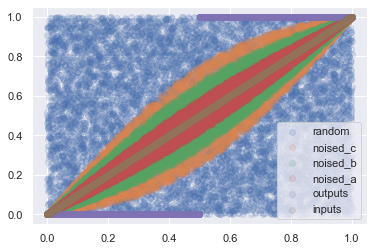

In [4]:
# Dispersão de todas as colunas do dataframe

fig, ax = plt.subplots()
ax.scatter(x=df.inputs, y=df.random, label="random", alpha=.15)
ax.scatter(x=df.inputs, y=df.noised_c, label="noised_c", alpha=.15)
ax.scatter(x=df.inputs, y=df.noised_b, label="noised_b", alpha=.15)
ax.scatter(x=df.inputs, y=df.noised_a, label="noised_a", alpha=.15)
ax.scatter(x=df.inputs, y=df.outputs, label="outputs", alpha=.15)
ax.scatter(x=df.inputs, y=df.inputs, label="inputs", alpha=.15)
ax.legend()

# 🤔 Pra que tudo isso?
- `inputs`: entrada ideal para determinar os `outputs`
- `noised_X`: variações do `inputs` com algum ruído. Ruído se intensifica apenas no centro para evitar a "desnormalização" dos dados (mesmo com o ruído, tudo fica entre 0 e 1)
- `inputs`: entrada aleatória que não deve apresentar correlação com `outputs`

### Regrassão com `inputs`:

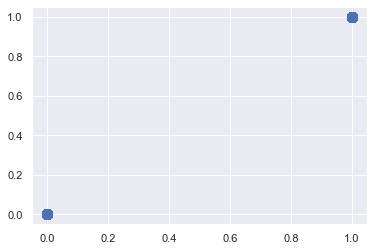

In [5]:
X = df[['inputs']]
y = df['outputs']

clf = LogisticRegression().fit(X, y)
y_pred = clf.predict(X)
y_proba = clf.predict_proba(X)

input_coefs = (clf.coef_[0][0], clf.intercept_[0])
plt.scatter(x=y, y=y_pred, s=100)

> regressão perfeita, nenhum falso positivo ou falso negativo

### Regrassão com `noised_a`:

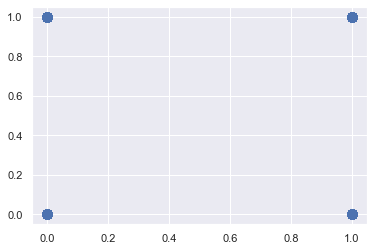

In [6]:
X = df[['noised_a']]
y = df['outputs']

clf = LogisticRegression().fit(X, y)
y_pred = clf.predict(X)
y_proba = clf.predict_proba(X)

noised_a_coefs = (clf.coef_[0][0], clf.intercept_[0])
plt.scatter(x=y, y=y_pred, alpha=0.01, s=100)

> regressão imperfeita, alguns falsos positivos e falsos negativos

# Comparando os coeficientes isolados

In [7]:
print('input_coefs:',input_coefs)
print('noised_a_coefs:',noised_a_coefs)

input_coefs: (25.430619174690186, -12.71529402057659)
noised_a_coefs: (22.227859572733315, -11.097058898179354)


### Conclusão1: Meu pensamento inicial estava errado.
O ruido afetou o coeficiente

# Vendo os coeficientes usando todas as variáveis

In [8]:
X = df[['inputs','noised_a','noised_b','noised_c','random']]
y = df['outputs']

clf = LogisticRegression().fit(X, y)
y_pred = clf.predict(X)
y_proba = clf.predict_proba(X)

original_coefs = pd.DataFrame(clf.coef_, columns=X.columns)
original_coefs['intercept'] = clf.intercept_[0]
original_coefs

,inputs,noised_a,noised_b,noised_c,random,intercept
0,16.266441,10.440724,4.744826,2.721737,-0.225271,-16.965691


# Vendo o efeito do fator multiplicativo em uma das entradas

In [9]:
X = df[['inputs','noised_a','noised_b','noised_c','random']].copy()
X['noised_a'] = X['noised_a'].map(lambda vals: vals*2)
y = df['outputs']

clf = LogisticRegression().fit(X, y)
y_pred = clf.predict(X)
y_proba = clf.predict_proba(X)

coefs = pd.DataFrame(clf.coef_, columns=X.columns)
coefs['intercept'] = clf.intercept_[0]

print("Original:")
print(original_coefs)
print('\n')
print("noised_a multiplicado:")
print(coefs)

Original:
      inputs   noised_a  noised_b  noised_c    random  intercept
0  16.266441  10.440724  4.744826  2.721737 -0.225271 -16.965691


noised_a multiplicado:
      inputs  noised_a  noised_b  noised_c    random  intercept
0  13.831039  9.046608  4.435897  2.679733 -0.282497 -19.365238


### Conclusão: Não consegui concluir nada 😥
Todos os coeficientes vão mudando, o que já complica um pouco e tem o intercept ( = $\beta_0$?) que também muda. Não consegui entender o padrão, o comportamento parece completamente diferente quando o fator multiplicaivo é: 2, 5, 10 e 100

# Iterando sobre P.G. de fatores multiplicativos pra tentar entender melhor

In [10]:
fatores_mult = [1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 4, 8, 16, 32]
factors_df = pd.DataFrame()

for fator in fatores_mult:
  X = df[['inputs','noised_a','noised_b','noised_c','random']].copy()
  X['noised_a'] = X['noised_a'].map(lambda vals: vals*fator)
  y = df['outputs']

  clf = LogisticRegression().fit(X, y)
  y_pred = clf.predict(X)
  y_proba = clf.predict_proba(X)

  coefs = pd.DataFrame(clf.coef_, columns=X.columns)
  coefs['intercept'] = clf.intercept_[0]
  coefs['fator'] = fator
  coefs.set_index('fator',inplace=True)

  factors_df = pd.concat([factors_df, coefs], axis=0)

factors_df


,inputs,noised_a,noised_b,noised_c,random,intercept
fator,,,,,,
0.03125,21.038048,0.681724,5.516272,3.010015,-0.165315,-14.705080
0.06250,21.004670,1.361994,5.509834,3.006976,-0.165700,-14.715389
0.12500,20.870412,2.685928,5.485849,2.996384,-0.166883,-14.755665
0.25000,20.376705,5.082119,5.399291,2.958832,-0.171314,-14.911819
0.50000,18.914167,8.416017,5.151754,2.857591,-0.186550,-15.466653
1.00000,16.266441,10.440724,4.744826,2.721737,-0.225271,-16.965691
2.00000,13.831039,9.046608,4.435897,2.679733,-0.282497,-19.365238
4.00000,12.578081,5.875131,4.317976,2.713398,-0.327946,-21.373614
8.00000,12.146465,3.224738,4.290104,2.738385,-0.348273,-22.293140


### Heatmap de tudo bruto

Text(0.5, 1.0, 'Heatmap coeficientes brutos')

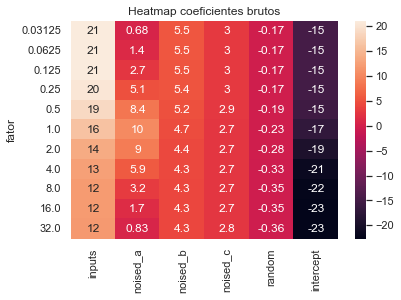

In [11]:
ax = sns.heatmap(factors_df, annot=True)
ax.set_title('Heatmap coeficientes brutos')

### Heatmap das colunas de maior interesse

Text(0.5, 1.0, 'Heatmap colunas de interesse (brutas)')

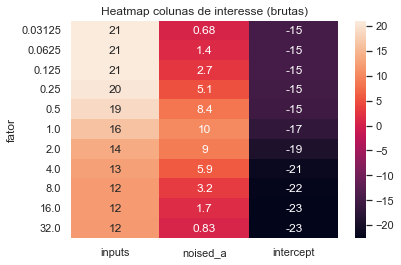

In [12]:
ax = sns.heatmap(factors_df.drop(['noised_b','noised_c','random'], axis=1), annot=True)
ax.set_title('Heatmap colunas de interesse (brutas)')

### normalizando por culunas (considerar apenas a relação entre linhas diferentes no heatmap)

In [13]:
def normalize(max,min):
  def func(val):
    if max==min:
      return val
    return (val-min)/(max-min)
  return func

,inputs,noised_a,noised_b,noised_c,random,intercept
fator,,,,,,
0.03125,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
0.06250,0.996312,0.069707,0.994795,0.990801,0.997982,0.998703
0.12500,0.981475,0.205370,0.975402,0.958729,0.991785,0.993635
0.25000,0.926918,0.450906,0.905418,0.845034,0.968579,0.973986
0.50000,0.765301,0.792529,0.705280,0.538504,0.888766,0.904173
1.00000,0.472714,1.000000,0.376271,0.127176,0.685940,0.715552
2.00000,0.203591,0.857146,0.126496,0.000000,0.386177,0.413621
4.00000,0.065133,0.532166,0.031154,0.101929,0.148107,0.160911
8.00000,0.017437,0.260581,0.008619,0.177581,0.041627,0.045209


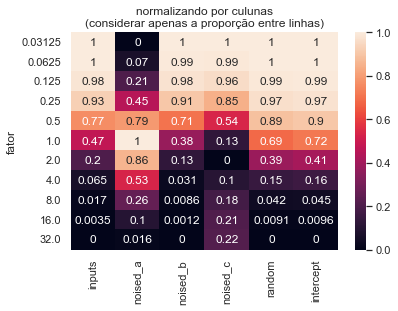

In [14]:
factors_df_norm = factors_df.copy()
for col in factors_df_norm:
  max = factors_df_norm[col].max()
  min = factors_df_norm[col].min()
  factors_df_norm[col] = factors_df_norm[col].map(normalize(max,min))

ax = sns.heatmap(factors_df_norm, annot=True)
ax.set_title('normalizando por culunas\n(considerar apenas a proporção entre linhas)')

factors_df_norm

### normalizando por linhas (considerar apenas a relação entre colunas diferentes no heatmap)

,inputs,noised_a,noised_b,noised_c,random,intercept
fator,,,,,,
0.03125,1.0,0.430483,0.565741,0.495622,0.406785,0.0
0.06250,1.0,0.450094,0.566215,0.496146,0.407325,0.0
0.12500,1.0,0.489574,0.568166,0.498288,0.409497,0.0
0.25000,1.0,0.566585,0.575573,0.506415,0.417714,0.0
0.50000,1.0,0.694651,0.599707,0.532979,0.444437,0.0
1.00000,1.0,0.824696,0.653299,0.592421,0.503742,0.0
2.00000,1.0,0.855874,0.716982,0.664080,0.574846,0.0
4.00000,1.0,0.802574,0.756710,0.709449,0.619871,0.0
8.00000,1.0,0.740946,0.771880,0.726824,0.637199,0.0


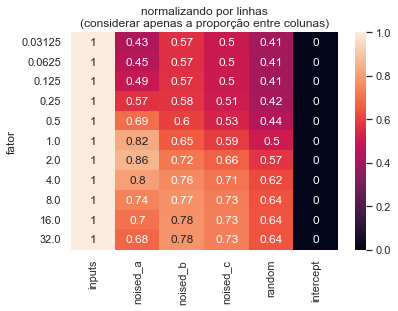

In [15]:
factors_df_norm = factors_df.copy().transpose()
for col in factors_df_norm:
  max = factors_df_norm[col].max()
  min = factors_df_norm[col].min()
  factors_df_norm[col] = factors_df_norm[col].map(normalize(max,min))

factors_df_norm = factors_df_norm.transpose()

ax = sns.heatmap(factors_df_norm, annot=True)
ax.set_title('normalizando por linhas\n(considerar apenas a proporção entre colunas)')

factors_df_norm

# Tentando forçar o aumento do coeficiente `noised_a` com fator multiplicativo:
- Spoiler: Não consegui fazer o coeficiente de `noised_a` superar o de `inputs`, mesmo multiplicando as entradas por um valor elevado (mas se em vez disso tivesse tentado reduzir o `inputs` daria certo)

- <strong style="color:#ff4545">Mas era pra conseguir, não era?</strong>

In [16]:
X = df[['inputs','noised_a','noised_b','noised_c','random']].copy()
X['noised_a'] = X['noised_a'].map(lambda vals: vals*10)     # Não deu
# X['noised_a'] = X['noised_a'].map(lambda vals: vals/10)     # Tbm não deu
# X['inputs'] = X['inputs'].map(lambda vals: vals/100)          # Esse deu
y = df['outputs']

clf = LogisticRegression().fit(X, y)
y_pred = clf.predict(X)
y_proba = clf.predict_proba(X)

coefs = pd.DataFrame(clf.coef_, columns=X.columns)
coefs['intercept'] = clf.intercept_[0]

print("Original:")
print(original_coefs)
print('\n')
print("noised_a multiplicado:")
print(coefs)

Original:
      inputs   noised_a  noised_b  noised_c    random  intercept
0  16.266441  10.440724  4.744826  2.721737 -0.225271 -16.965691


noised_a multiplicado:
      inputs  noised_a  noised_b  noised_c    random  intercept
0  12.084609  2.612525  4.284634  2.743888 -0.351192 -22.424245


# Vendo o efeito do fator multiplicativo em uma das entradas em casos isolados

In [17]:
X = df[['noised_a']]
y = df['outputs']

clf = LogisticRegression().fit(X, y)
y_pred = clf.predict(X)
y_proba = clf.predict_proba(X)

input_coefs = (clf.coef_[0][0], clf.intercept_[0])

In [18]:
X = df[['noised_a']].copy()
X['noised_a'] = X['noised_a']*2
y = df['outputs']

clf = LogisticRegression().fit(X, y)
y_pred = clf.predict(X)
y_proba = clf.predict_proba(X)

input_coefs_2 = (clf.coef_[0][0], clf.intercept_[0])

In [19]:
X = df[['noised_a']].copy()
X['noised_a'] = X['noised_a']/2
y = df['outputs']

clf = LogisticRegression().fit(X, y)
y_pred = clf.predict(X)
y_proba = clf.predict_proba(X)

input_coefs_3 = (clf.coef_[0][0], clf.intercept_[0])

#### Comparando os coeficientes

In [20]:
print("Entrada dividida:",input_coefs_3)
print("Com entrada original:",input_coefs)
print("Entrada multiplicada:",input_coefs_2)

Entrada dividida: (30.189564633090004, -7.536122743789212)
Com entrada original: (22.227859572733315, -11.097058898179354)
Entrada multiplicada: (14.983221061171188, -14.960659337619441)


# Conclusão: 🤷
Havia me esquecido que, além do $\beta_1$, também tinha o $\beta_0$ para ser considerado.

Pra esse caso isolado as coisas parecem fazer mais sentido, a "entrada dividida" acaba tendo coeficiente menor pois uma variação menor na entrada resulta numa alteração maior esperada pro cálculo da saída (eu acho)